<a href="https://colab.research.google.com/github/beepmo/gator/blob/main/data/07-18/miracle2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install impedance -q


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 968.2 kB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from google.colab import userdata
import plotly.express as px
from impedance import preprocessing
from impedance.models.circuits import CustomCircuit

In [ ]:
!git config --global user.email {userdata.get('email')}
!git config --global user.name {userdata.get('name')}
!git clone https://{userdata.get('token')}@github.com/beepmo/gator
%pwd

In [ ]:
%cd "/content/gator/data/06-20/"

# 20-06-24 LiTaO3 gating

First part : measurement of the current without any gating nor liquid

Seconde part : Adding IL without gating

Then gating, electrode on, no gating voltage

Finally : gating
- Frequency : 0.1 Hz
- Amplitude : 1 Vpp
- Offset : 870 mV
- Duty Cycle : 75%







# Base Time
06/20/2024 12:42:09

In [ ]:
# prompt: delete first 8 lines from full_buffer.csv

def prep_csv(filename):

  # Read the full buffer into a list of lines
  with open(filename, 'r') as f:
    lines = f.readlines()

  # print base time
  print(lines[2])

  # Delete the first 8 lines
  lines = lines[8:]

  # Write the remaining lines back to the file
  with open(filename, 'w') as f:
    f.writelines(lines)

In [ ]:
prep_csv('defbuffer1_0620_124209.csv')
df = pd.read_csv('defbuffer1_0620_124209.csv')


In [ ]:
df

In [ ]:
# Time (s)
T = df['Relative Time']

# Current (mA)
I = df['Reading'] * 1e9

# Potential (mV)
V = df['Value'] * 1e3

In [ ]:
cut1 = 0
cut2 = 509
plt.plot(T[cut1:cut2],I[cut1:cut2],'.')
plt.ylabel('Current (nA)')
plt.xlabel('Time (s)')

# Adding a drop of IL

Signal is smoothed without increase in conductivity. We suspect this is due to ionic liquid shielding static charges.

In the smoothed signal, we identify a signal with 10s period and 50% duty cycle. This corresponds to the square wave being output on the Keysight signal generator. Its output is connected to the PCB (`GND` and `GATE`). A copper strip goes off one side of the `GATE` pad but no LMO electrode is connected.

Possible reasons for the `GATE` signal to show up in src-drn current:
- `GND` is shifted by the Keysight generator signal.
- Asymmetric voltage (through the resisting PCB) biases the SRC vs DRN voltage.

In [ ]:
# We can see the adding of IL

cut1 = 510
cut2 = 1131
plt.plot(T[cut1:cut2],I[cut1:cut2],'.')
plt.ylabel('Current (nA)')
plt.xlabel('Time (s)')

# Installed gate, but touched DRN-SRC wires together

Keithley limit 0.1mA is visible haha

After the incident (first contact with LMO electrode?) drn-src current jumped from 1nA to 500nA.

In [ ]:
# Fixed voltage and beginning of gating, but with short cut

cut1 = 1132
cut2 = 14000
plt.plot(T[cut1:cut2],I[cut1:cut2],'.')
plt.ylabel('Current (nA)')
plt.xlabel('Time (s)')

# Actual gating
In between the gating, we changed the gating electrode placement, to obtain a stable open circuit voltage.

In `px` plot it is clear that each gating attempt increases conductivity.

In [ ]:
# Gating

cut1 = 28678
cut2 = len(T)
plt.plot(T[cut1:cut2],I[cut1:cut2],'.')
plt.ylabel('Current (nA)')
plt.xlabel('Time (s)')

Increase in conductivity with every gating cycle

In [ ]:
cut1 = 28678
cut2 = len(T)
plt.plot(T[cut1:cut2],V[cut1:cut2],'.')
plt.ylabel('Voltage (mV)')
plt.xlabel('Time (s)')

In [ ]:
df_new = df[['Relative Time', 'Value', 'Reading']]
df_new.loc[:, 'Reading'] = df_new['Reading'] * 1e9
df_new.loc[:, 'Value'] = df_new['Value'] * 100
df_new.rename(columns={'Reading': 'Current (nA)', 'Value': 'Vds (1e-2 V)'}, inplace=True)

In [ ]:
# prompt: generately plotly express scatter plots of current and voltage over time from df_new

# fig = px.scatter(df_new, x="Relative Time", y=["Current (nA)", "Vds (1e-2 V)"])
fig = px.scatter(df_new, x="Relative Time", y=["Current (nA)"])
fig.show()

In [ ]:
df_new = df[['Relative Time', 'Value', 'Reading']]
df_new.loc[:, 'Reading'] = df_new['Reading'] * 1e9
df_new.loc[:, 'Value'] = df_new['Value'] * 100
df_new.rename(columns={'Reading': 'Current (nA)', 'Value': 'Vds (1e-2 V)'}, inplace=True)

In [ ]:
# prompt: generately plotly express scatter plots of current and voltage over time from df_new

# fig = px.scatter(df_new, x="Relative Time", y=["Current (nA)", "Vds (1e-2 V)"])
fig = px.scatter(df_new, x="Relative Time", y=["Vds (1e-2 V)"])
fig.show()

# EIS on gated sample



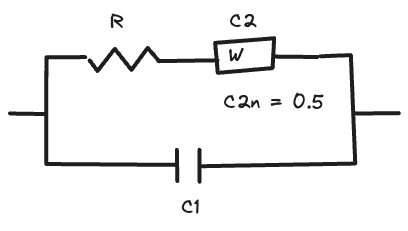

## High to low sweep

In [ ]:
freqs, Z = preprocessing.readZPlot('LiTao3_htol.z')
freqs, Z = np.delete(freqs, 32), np.delete(Z, 32) # remove 1 noise point (argmin(Z.imag))

circuit = 'p(R0-W0,C0)'
init = [10**6, 10**-7, 10**-8]

circuit = CustomCircuit(circuit, initial_guess=init)
circuit.fit(freqs, Z)
Z_fit = circuit.predict(freqs)

plt.plot(Z.real, -Z.imag, 'o')
plt.plot(Z_fit.real, -Z_fit.imag, '.')
plt.ylabel('Imaginary')
plt.xlabel('Real')
plt.title('Nyquist')
plt.show()

plt.plot(freqs, -Z.imag, 'o')
plt.plot(freqs, -Z_fit.imag, '.')
plt.ylabel('Im(Z)')
plt.xlabel('freq')
plt.title('Bode')
plt.show()

plt.plot(freqs, Z.real, 'o')
plt.plot(freqs, Z_fit.real, '.')
plt.ylabel('Re(Z)')
plt.xlabel('freq')
plt.title('Bode')
plt.show()

In [ ]:
print(circuit)

## Low to high sweep

In [ ]:
freqs, Z = preprocessing.readZPlot('LiTao3_ltoh.z')
freqs, Z = np.delete(freqs, 28), np.delete(Z, 28) # remove 1 noise point (argmin(Z.imag))

circuit = 'p(R0-W0,C0)'
init = [10**6, 10**-7, 10**-8]

circuit = CustomCircuit(circuit, initial_guess=init)
circuit.fit(freqs, Z)
Z_fit = circuit.predict(freqs)

plt.plot(Z.real, -Z.imag, 'o')
plt.plot(Z_fit.real, -Z_fit.imag, '.')
plt.ylabel('Imaginary')
plt.xlabel('Real')
plt.title('Nyquist')
plt.show()

plt.plot(freqs, -Z.imag, 'o')
plt.plot(freqs, -Z_fit.imag, '.')
plt.ylabel('Im(Z)')
plt.xlabel('freq')
plt.title('Bode')
plt.show()

plt.plot(freqs, Z.real, 'o')
plt.plot(freqs, Z_fit.real, '.')
plt.ylabel('Re(Z)')
plt.xlabel('freq')
plt.title('Bode')
plt.show()

In [ ]:
print(circuit)

# Add resistors for ionic (gets warburg), electronic in parallel

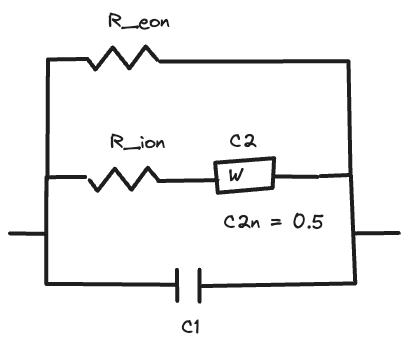

In [ ]:
freqs, Z = preprocessing.readZPlot('LiTao3_ltoh.z')
freqs, Z = np.delete(freqs, 28), np.delete(Z, 28) # remove 1 noise point (argmin(Z.imag))

circuit = 'p(p(R0-W0,R1),C0)'
init = [10**6, 10**4, 10**9, 10**-12]

circuit = CustomCircuit(circuit, initial_guess=init)
circuit.fit(freqs, Z)
Z_fit = circuit.predict(freqs)

plt.plot(Z.real, -Z.imag, 'o')
plt.plot(Z_fit.real, -Z_fit.imag, '.')
plt.ylabel('Imaginary')
plt.xlabel('Real')
plt.title('Nyquist')
plt.show()

plt.plot(freqs, -Z.imag, 'o')
plt.plot(freqs, -Z_fit.imag, '.')
plt.ylabel('Im(Z)')
plt.xlabel('freq')
plt.title('Bode')
plt.show()

plt.plot(freqs, Z.real, 'o')
plt.plot(freqs, Z_fit.real, '.')
plt.ylabel('Re(Z)')
plt.xlabel('freq')
plt.title('Bode')
plt.show()

In [ ]:
print(circuit)

# Make depressed semicircle
Problem: least squares tends to decrease CPE $n$ too much.

In [ ]:
freqs, Z = preprocessing.readZPlot('LiTao3_ltoh.z')
freqs, Z = np.delete(freqs, 28), np.delete(Z, 28) # remove 1 noise point (argmin(Z.imag))

circuit = 'p(p(R0-W0,R1),CPE0)'
init = [1.24*10**6, 2.45*10**5, 3.25*10**7, 6.65*10**-1, 1]

circuit = CustomCircuit(circuit, initial_guess=init)
circuit.fit(freqs, Z, verbose=True)
Z_fit = circuit.predict(freqs)

plt.plot(Z.real, -Z.imag, 'o')
plt.plot(Z_fit.real, -Z_fit.imag, '.')
plt.ylabel('Imaginary')
plt.xlabel('Real')
plt.title('Nyquist')
plt.show()

plt.plot(freqs, -Z.imag, 'o')
plt.plot(freqs, -Z_fit.imag, '.')
plt.ylabel('Im(Z)')
plt.xlabel('freq')
plt.title('Bode')
plt.show()

# Constant current polarization

A constant current is set to 1µA (measured 0.925-0.95µA). Voltage measured across the sample increases exponentially, from 1.5V to 3.5V.

The mixed conductor model (Maier p445-454) tells us
$$
U=IR_{eon}\left( 1-\frac{R_{\text{eon}}}{R_{\text{eon}}+R_{\text{ion}}}\exp\left( -\frac{t}{\tau} \right) \right)
$$
where
$$
\tau=(R_{\text{eon}}+R_{\text{ion}})C^{\delta}.
$$

Maier explains how the diffusion coefficient $D$ is given by $\tau$,
$$
D^{\delta}=\frac{4L^2}{\pi  ^{2}\tau }.
$$

We have $\log(U(\infty)-U(t))$ linear in $t$ and fit to obtain $\tau=3.75\cdot 10^{-4} \mathrm{\frac{1}{s}}$. Lower bounding $L\geq 1\cdot 10^{-3}\text{ m}$, we find
$$
D^{\delta}\geq 1\cdot 10^{-3} \mathrm{\frac{m^{2}}{s}}.
$$
This is huge! Let's bug shoot. The most pertinent bug lies in assuming homogeneous lateral planes when we introduce $L$.

In [ ]:
prep_csv('polarization.csv')

In [ ]:
df = pd.read_csv('polarization.csv')

In [ ]:
df

In [ ]:
# Time (s)
T = df['Relative Time']

# Current (mA)
I = df['Value'] * 1e9

# Potential (mV)
V = df['Reading'] * 1e3

In [ ]:
plt.plot(T, I)
plt.ylabel('Current (nA)')
plt.xlabel('Time (s)')
plt.xlim(100)
plt.ylim(800)

In [ ]:
df_new = df[['Relative Time', 'Value', 'Reading']]
df_new.loc[:, 'Reading'] = df_new['Reading'] * 1e9
df_new.loc[:, 'Value'] = df_new['Value'] * 100
df_new.rename(columns={'Reading': 'Current (nA)', 'Value': 'Vds (1e-2 V)'}, inplace=True)

In [ ]:
fig = px.scatter(df, x="Relative Time", y=["Reading"])
fig.show()


In [ ]:
c1 = 1000
plt.plot(T[c1:],np.log(V[len(T)-1] * np.ones_like(T) - V)[c1:])
plt.xlim(0,4000)
plt.ylim(4,7)
plt.xlabel('Time (s)')

In [ ]:
-1.5/4000